In [109]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pylab as plt

import DDPG
import torch

## Helper Functions

In [110]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)    

In [111]:
def run(env, agent, n_episodes=100, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            state, reward, done, _trunc, _info = env.step(action)
            observations.append(state)
            actions.append(action)
            ep_reward += reward
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
    print(f'Mean reward: {np.mean(rewards)}')
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

# DDPG

In [112]:
env_name = "Pendulum-v1"

eps=0.1
ts=32
lr=0.0001
s=None

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses = np.array([(loss[0].item(), loss[1]) for loss in data["losses"]])

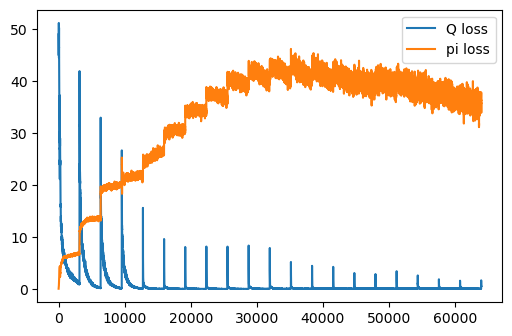

In [113]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(losses[:,0],10),label=f"Q loss")
plt.plot(running_mean(losses[:,1],10),label=f"pi loss")
plt.legend()

TODO: Plot the rewards and the dependency on the hyperparameters

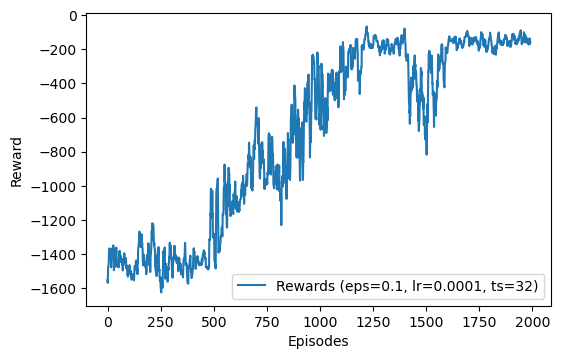

In [114]:
fig = plt.figure(figsize=(6, 3.8))
plt.plot(running_mean(rewards, 10), label=f"Rewards (eps={eps}, lr={lr}, ts={ts})")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()


## value function

In [115]:
def plot_Q_function(q_function, observations, actions, plot_dim1=0, plot_dim2=2,
                    label_dim1="cos(angle)", label_dim2="angular velocity"):
    plt.rcParams.update({'font.size': 12})
    values =q_function.predict(np.hstack([observations,actions]))
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot()
    surf = ax.scatter (observations[:,plot_dim1], observations[:,plot_dim2],  c = values, cmap=cm.coolwarm)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)

    return fig

In [116]:
env = gym.make(env_name)

In [117]:
episodes=2000
eps=0.1
ts=32
lr=0.0001
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

TODO: 

Initialize the DDPGAgent and load the checkpoint 

run 100 runs with noise 0.2 (see run function)

use the helper function above to plot the Q function

In [118]:
# Initialize the agent
agent = DDPG.DDPGAgent(env.observation_space, env.action_space)

# Load the checkpoint
checkpoint_data = torch.load(checkpoint)
agent.restore_state(checkpoint_data)

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32) Box(-2.0, 2.0, (1,), float32)


TypeError: Feedforward.__init__() missing 3 required positional arguments: 'input_size', 'hidden_sizes', and 'output_size'

In [ ]:
# Run 100 episodes with noise 0.2
observations, actions, rewards = run(env, agent, n_episodes=100, noise=0.2)

In [ ]:
# Plot the Q-function
label_dim1, label_dim2 = "cos(angle)", "angular velocity"
fig = plot_Q_function(agent.Q, observations, actions, 
                      plot_dim1=0, plot_dim2=2, 
                      label_dim1=label_dim1, label_dim2=label_dim2)

plt.show()

Bonus: Have we done the right thing? We run the policy with noise to see different states. Are the Q-values actually correct? Can you fix it?

## HalfCheetah

In [107]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video

# Load the trained policy
policy_path = "./results/DDPG_HalfCheetah-v4_6000-eps0.1-t32-l0.0001-s1.pth"

# Create the environment and initialize the agent
env = gym.make("HalfCheetah-v4")
ddpg = DDPG.DDPGAgent(env.observation_space, env.action_space)

# Load the saved policy state
saved_state = torch.load(policy_path)
ddpg.restore_state(saved_state)

# Test the policy in the environment
def test_policy(agent, env, episodes=5, max_timesteps=1000, render=True):
    for episode in range(episodes):
        observation, _ = env.reset()
        total_reward = 0

        for t in range(max_timesteps):
            if render:
                env.render()
            action = agent.act(observation, eps=0)
            observation, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if done or truncated:
                break

        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    env.close()

# Run the test
test_policy(ddpg, env, episodes=2, render=True)

# Record a video of the policy
video_env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda x: True)

# Test the policy while recording
test_policy(ddpg, video_env, episodes=1, render=False)

# Display the recorded video
video_path = "./videos/rl-video-episode-0.mp4" 
Video(video_path, embed=True)


TypeError: Feedforward.__init__() missing 3 required positional arguments: 'input_size', 'hidden_sizes', and 'output_size'